# Sistema de Recomendación Interactivo con Embeddings de Palabras usando Word2Vec, Plotly, y NetworkX

¡Bienvenido a este proyecto! Vamos a explorar cómo construir un modelo que pueda entender las palabras de una manera matemática, de manera que las palabras con significados similares que comparten ciertas características estén cerca unas de otras en el espacio vectorial. Es una forma elegante de decir que las representaciones matemáticas de las palabras que tienen un significado similar están cerca unas de otras, y las palabras que no comparten mucho significado están más alejadas. Demostraremos que este modelo puede adaptarse para ser utilizado en un sistema de recomendación, o como una herramienta de descubrimiento (es decir, no tenemos esto en stock, ¿tal vez le gustaría esta alternativa?).


## Desglose del proyecto

- [1 - Introducción](#1)
- [2 - Análisis Exploratorio de Datos y Preprocesamiento](#2)
- [3 - Word2Vec con Gensim](#3)
- [4 - Exploración de resultados](#4)
- [5 - Construir y visualizar un gráfico de red interactivo](#5)
- [6 - Graded Quiz: Test your Project Understanding](#6)

<a name='1'></a>
## 1. Introducción

Utilizaremos un conjunto de datos de recetas para entrenar un modelo que aprenda las interacciones entre los distintos tipos de ingredientes y los productos disponibles en un supermercado. Este modelo puede aplicarse de varias maneras, por ejemplo:

- Para recomendar productos en función de los artículos añadidos a la cesta;
- Para ofrecer productos alternativos en función de las existencias;
- Descubrir nuevos productos para crear diferentes recetas.

### Muestra

*Asado de punta de solomillo aliñado con hierbas*

- 1 1/4 cucharadas de pimentón
- 1 cucharada de sal kosher
- 1 cucharadita de ajo en polvo
- 1/2 cucharadita de pimienta negra molida
- 1/2 cucharadita de cebolla en polvo
- 1/2 cucharadita de pimienta de cayena molida
- 1/2 cucharadita de orégano seco
- 1/2 cucharadita de tomillo seco
- 2 cucharadas de aceite de oliva
- 1 (3 libras) de asado de punta de solomillo

En un bol pequeño, mezcle el pimentón, la sal kosher, el ajo en polvo, la pimienta negra, la cebolla en polvo, la pimienta de cayena, el orégano y el tomillo. Añada el aceite de oliva y deje reposar la mezcla unos 15 minutos.

Precalentar el horno a 350 grados F (175 grados C). Forre una bandeja de horno con papel de aluminio.

Coloque el asado en la bandeja de horno preparada y cúbralo por todos los lados con la mezcla de especias.

Asar 1 hora en el horno precalentado, o hasta una temperatura interna mínima de 145 grados F (63 grados C). Dejar reposar 15 minutos antes de cortar.

### ¡Veamos una demostración!

[¡Haga clic aquí!](Data/demo.html)

En dicha demo se ve una visualización de word embedding. cada uno de estos nodos representa un ingrediente, los cuales tienen links entre ellos en una forma semantica de agrupamiento. Por ejemplo, a la izquierda puede ver raspberries, blackberries y blueberries, lo que significa que estos tres items obviamente estan relacionados. Evidentemente vemos que se puede construir un modelo que puede relacionar estas tres palabras sin que le digamos nada.

También se pueden ver otras agrupaciones como tipos de pastas, diferentes tipos de quesos, diferentes tipos de frutos secos, pacanas y nueces, diferentes tipos de edulcorantes artificiales.
Es realmente genial la fuerza de un modelo como este, y vamos a realmente entrar en cómo podemos construir esto y lo poderoso puede llegar a ser.

<a name='2'></a>
## 2. Análisis Exploratorio de Datos y Preprocesamiento

[Este es el dataset](https://eightportions.com/datasets/Recipes/#fn:1) que vamos a utilizar. Ha sido recopilada por Ryan Lee, y se ha extraído de [Food Network](https://www.foodnetwork.com/), [Epicurious](https://www.epicurious.com/), y [Allrecipes](https://www.allrecipes.com/).

In [1]:
# Importaciones necesarias
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
import pandas as pd
import pickle
import string
import json
import os

In [2]:
# Listamos la infromación dentro de la carpeta Dataset
os.listdir("./data/Dataset/")

['LICENSE',
 'recipes_raw_nosource_ar.json',
 'recipes_raw_nosource_epi.json',
 'recipes_raw_nosource_fn.json']

In [3]:
# hacemos una lista con las recetas provenientes de las tres paginas web mencionadas anteriormente
# Estas siglas son las que aparecen al final del nombre del documento de los archivos .json
recipe_sources = ['ar', 'epi', 'fn']

In [4]:
# Para visualizar los diccionarios .json
temp = json.load(open('Data/Dataset/recipes_raw_nosource_ar.json'))
temp

{'rmK12Uau.ntP510KeImX506H6Mr6jTu': {'title': 'Slow Cooker Chicken and Dumplings',
  'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT',
   '2 tablespoons butter ADVERTISEMENT',
   '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT',
   '1 onion, finely diced ADVERTISEMENT',
   '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT',
   'ADVERTISEMENT'],
  'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n',
  'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'},
 '5ZpZE8hSVdPk2ZXo1mZTyoPWJRSCPSm': {'title': 'Awesome Slow Cooker Pot Roast',
  'ingredients': ['2 (10.75 ounce) cans condensed cream of mushroom soup ADVERTISEMENT',
   '1 (1 ounce) package dry onion soup mix ADVERTISEME

In [5]:
# Genera un DataFrame
df = pd.DataFrame()
# Declara cuatro listas vacias
sources, titles, ingredients, instructions = [], [], [], []
# Con este bucle rellena esas listas vacías con la información deseada
for recipe_source in recipe_sources:
    data = json.load(open(f'data/Dataset/recipes_raw_nosource_{recipe_source}.json', 'r'))
    for _, recipe in data.items():
        # Este if lo que hace es seleccionar las recetas que tenga tanto el titulo, 
        # los ingrediente y las instrucciones
        if ('title' in recipe) and ('ingredients' in recipe) and ('instructions' in recipe):
            # añadir a una lista de la fuente
            sources.append(recipe_source)
            # añadir a una lista de la titulos
            titles.append(recipe["title"])
            # añadir a una lista de listas de ingredientes, removiendo las palabra ADVERTISEMENT
            ingredients.append([str.replace(ing, "ADVERTISEMENT", "") for ing in recipe["ingredients"]])             
            # añadir a una lista de instrucciones, eliminando la palabra ADVERTISEMENT 
            # y remplazando \n por un "".
            instructions.append(str(recipe['instructions']).replace("ADVERTISEMENT", "").replace("\n", ""))
df['source'] = sources
df['title'] = titles
df['ingredients'] = ingredients
df['instructions'] = instructions

In [6]:
# Visualizamos el DataFrame
df.head()

,source,title,ingredients,instructions
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves , ...","Place the chicken, butter, soup, and onion in ..."
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar , 1/2 cup ketchup ...",Preheat oven to 350 degrees F (175 degrees C)....
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened , 1 cup white sugar , ...",Preheat oven to 350 degrees F (175 degrees C)....
4,ar,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta , 3 cups fr...",Preheat oven to 350 degrees F. Line a 2-quart ...


In [7]:
# El siguiente paso de preprocesamiento es remover algunas 
# palabras que no son importantes para este problema en particular
to_remove = [
    'tablespoon',
    'tablespoons',
    'teaspoon',
    'teaspoons',
    'tsp',
    'tsps',
    'tbsp',
    'tbsps',
    'pound',
    'pounds',
    'grams',
    'mg',
    'ounce'
    'ounces',
    'kg',
    'crushed',
    'chopped',
    'finely',
    'softened',
    'cups',
    'cup'
]

In [8]:
# También se remueven signos de puntuación y digitos
# Visualizamos a cuales nos referimos
print(string.punctuation)
print(string.digits)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
0123456789


In [9]:
ord("!"), chr(33)

(33, '!')

In [10]:
# Para eliminar esas palabras y signos se hace lo siguiente
translate_table =  str.maketrans("","",string.punctuation+string.digits)
print(translate_table)

{33: None, 34: None, 35: None, 36: None, 37: None, 38: None, 39: None, 40: None, 41: None, 42: None, 43: None, 44: None, 45: None, 46: None, 47: None, 58: None, 59: None, 60: None, 61: None, 62: None, 63: None, 64: None, 91: None, 92: None, 93: None, 94: None, 95: None, 96: None, 123: None, 124: None, 125: None, 126: None, 48: None, 49: None, 50: None, 51: None, 52: None, 53: None, 54: None, 55: None, 56: None, 57: None}


In [11]:
# Veamos un ejemplo de como funciona translate_table
saludo = "Holas!!!!. como estan??"
saludo.lower().translate(translate_table)

'holas como estan'

In [12]:
remove_stopwords(saludo)

'Holas!!!!. como estan??'

In [13]:
# Hacemos una función para el preprocesamiento de la información
# En la funcion ingresa una lista de items
def preprocess(items):
    translate_table =  str.maketrans("","",string.punctuation+string.digits)
    res = []
    # Se recorre cada elemento de la lista item y se hace el preprocesamiento
    for item in items:
        temp = item.lower().replace("-","")
        temp = temp.translate(translate_table)
        temp = remove_stopwords(temp)
        # Se reemplaza por un espacio vacio cada stop_word
        for stop_word in to_remove:
            temp = temp.replace(stop_word,"")
        # Se agrega a la lista vacía las palabras restantes es forma de lista por cada palabra
        res.append(temp.split())
        
    return res

In [14]:
# Veamos un ejemplo de como funciona la función
print(preprocess (["""Place the chicken, butter, soup, and onion in a slow cooker, 
and fill with enough water to cover.Cover, and cook for 5 to 6 hours on High. 
About 30 minutes before serving, place the torn biscuit dough in the slow cooker. 
Cook until the dough is no longer raw in the center."""]))

[['place', 'chicken', 'butter', 'soup', 'onion', 'slow', 'cooker', 'water', 'covercover', 'cook', 'hours', 'high', 'minutes', 'serving', 'place', 'torn', 'biscuit', 'dough', 'slow', 'cooker', 'cook', 'dough', 'longer', 'raw', 'center']]


In [15]:
# Veamos como se ve una instrucción del DataFrame
instrucciones = df.instructions.values
print(instrucciones[0]) # Cambiando el indice se pueden ver otras instrucciones

Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.


In [16]:
# Veamos como se ven los ingredientes del DataFrame
# En este caso ingredients es una lista de listas, por eso se usa join(x)
ingredientes =  [", ".join(x) for  x in df.ingredients.values.tolist()]
ingredientes[0]

'4 skinless, boneless chicken breast halves , 2 tablespoons butter , 2 (10.75 ounce) cans condensed cream of chicken soup , 1 onion, finely diced , 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces , '

In [17]:
# Finalmente obtenemos los datos para el entrenamiento preprocesados
train_data = preprocess(instrucciones+ingredientes)

In [18]:
# Veamos un ejemplo dentro de los datos de entrenamiento
print(train_data[0])

['place', 'chicken', 'butter', 'soup', 'onion', 'slow', 'cooker', 'water', 'covercover', 'cook', 'hours', 'high', 'minutes', 'serving', 'place', 'torn', 'biscuit', 'dough', 'slow', 'cooker', 'cook', 'dough', 'longer', 'raw', 'center', 'skinless', 'boneless', 'chicken', 'breast', 'halves', 's', 'butter', 'ounce', 'cans', 'condensed', 'cream', 'chicken', 'soup', 'onion', 'diced', 'ounce', 'packages', 'refrigerated', 'biscuit', 'dough', 'torn', 'pieces']


In [19]:
# Veamos la cantidad de datos de entrenamiento
len(train_data)

124647

In [20]:
# guardamos los datos en un archivo pickle de python
with open("train_data.pkl", "wb") as file:
    pickle.dump(train_data, file)

<a name='3'></a>
## 3. Word2Vec con Gensim

Lo que vimos en la primera tarea, básicamente es cómo un modelo aprende una representación de cada palabra en un corpus dado. De manera que las palabras que tienen algún tipo de significado semántico existen cerca unas de otras en el espacio vectorial. Lo que significa que las palabras que tienen algún tipo de contexto similar en el lenguaje humano existirán cerca unas de otras en las presentaciones vectoriales matemática. Así, por ejemplo, un gato y un perro pueden estar muy relacionados. Los dos vectores de entonces, por ejemplo, un perro y un balón de fútbol estarán un poco más separados. 

Los documentos originales de Word2Vec pueden encontrarse [aquí](https://arxiv.org/pdf/1301.3781.pdf) y [aquí](https://arxiv.org/pdf/1310.4546.pdf), mientras que la documentación del modelo Gensim puede encontrarse [aquí](https://radimrehurek.com/gensim/models/word2vec.html).

Esencialmente, estos son dos enfoques diferentes: **CBOW** (bolsa de palabras) y **Skip Graham**. 

- En el modelo CBOW usted entrena una red neuronal para tomar en una cierta cantidad de palabras como entrada y para predecir la palabra media. Así que, por ejemplo, si estás viendo la palabra $w(t)$, tomará como contexto las dos palabras anteriores y las dos palabras posteriores en este ejemplo. Algunos de estos vectores intentan predecir la palabra que está en el medio. 

- En el modelo Skip Graham básicamente ya tienes una entrada, y tratas de predecir las palabras que la rodean. Así que esto es una especie de opuestos entre sí. Pero están logrando lo mismo y que están aprendiendo un contexto alrededor de la palabra dada y luego predecir esa palabra o predecir el contexto. 

![Word2Vec architecture](data/word2vec.jpeg)

Usaremos Word2Vec en su forma más básica en la configuración por defecto, que en realidad está configurada para ser una bolsa continua de palabras (CBOW). Y la razón por la que creo que esto es bastante importante es que en nuestro caso, realmente no nos importa el orden de las palabras, mientras que está Skip Graham está más inclinado a ese propósito. Así que, por ejemplo, si alguien dice, las patatas dos, o dos patatas, queremos clasificar y aprender sobre él de la misma manera. 

In [21]:
# Hacemos la importación del modelo word2vec
from gensim.models.word2vec import Word2Vec

In [22]:
# Abrimos el archivo con los datos de entrenamiento
with open("train_data.pkl","rb") as file:
    train_set = pickle.load(file)

In [23]:
# Veamos las primeras 5 entradas de los datos
print(*train_set[:5],sep="\n\n")

['place', 'chicken', 'butter', 'soup', 'onion', 'slow', 'cooker', 'water', 'covercover', 'cook', 'hours', 'high', 'minutes', 'serving', 'place', 'torn', 'biscuit', 'dough', 'slow', 'cooker', 'cook', 'dough', 'longer', 'raw', 'center', 'skinless', 'boneless', 'chicken', 'breast', 'halves', 's', 'butter', 'ounce', 'cans', 'condensed', 'cream', 'chicken', 'soup', 'onion', 'diced', 'ounce', 'packages', 'refrigerated', 'biscuit', 'dough', 'torn', 'pieces']

['slow', 'cooker', 'mix', 'cream', 'mushroom', 'soup', 'dry', 'onion', 'soup', 'mix', 'water', 'place', 'pot', 'roast', 'slow', 'cooker', 'coat', 'soup', 'mixturecook', 'high', 'setting', 'hours', 'low', 'setting', 'hours', 'ounce', 'cans', 'condensed', 'cream', 'mushroom', 'soup', 'ounce', 'package', 'dry', 'onion', 'soup', 'mix', 'water', 's', 'pot', 'roast']

['preheat', 'oven', 'degrees', 'f', 'degrees', 'c', 'lightly', 'grease', 'x', 'inch', 'loaf', 'panpress', 'brown', 'sugar', 'prepared', 'loaf', 'pan', 'spread', 'ketchup', 'sugar

In [24]:
# Definimos el modelo
model = Word2Vec()

In [25]:
# Para averiguar los hiperparámetros que se pueden ajustar
model?

Type:            Word2Vec
String form:     Word2Vec<vocab=0, vector_size=100, alpha=0.025>
File:            c:\programdata\anaconda3\lib\site-packages\gensim\models\word2vec.py
Docstring:       <no docstring>
Class docstring:
Serialize/deserialize objects from disk, by equipping them with the `save()` / `load()` methods.

Warnings
--------
This uses pickle internally (among other techniques), so objects must not contain unpicklable attributes
such as lambda functions etc.
Init docstring: 
Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.

Once you're finished training a model (=no more updates, only querying)
store and use only the :class:`~gensim.models.keyedvectors.KeyedVectors` instance in ``self.wv``
to reduce memory.

The full model can be stored/loaded via its :meth:`~gensim.models.word2vec.Word2Vec.save` and
:meth:`~gensim.models.word2vec.Word2Vec.load` methods.

The trained word vectors can also be stored/loaded from a format compatible w

In [26]:
# Construimos el vocabulario de los datos de entrenamiento
model.build_vocab(train_set)

In [27]:
# Veamos el tamaño del corpus construido
corpus_count = model.corpus_count
corpus_count

124647

In [28]:
# Veamos cuantos epoch por defecto tiene el modelo
epochs = model.epochs
epochs

5

In [29]:
# Hacemos el entrenamiento

#%%time
model.train(train_data,
            total_examples = corpus_count,
            epochs = epochs)

(66517301, 79318715)

In [30]:
# Veamos las palabras mas parecidas a una determinada palabra
# se pasa una lista de palabras y la cantidad de palabras relacionadas que se quieren
model.wv.most_similar(["ketchup"],topn=20)

[('heinz', 0.6586567759513855),
 ('heinz®', 0.6302465200424194),
 ('worcestershire', 0.6167559027671814),
 ('mayo', 0.6118567585945129),
 ('spicy', 0.5745418071746826),
 ('relish', 0.5720633864402771),
 ('catsup', 0.5719086527824402),
 ('sriracha', 0.5706337690353394),
 ('molasses', 0.5603621006011963),
 ('barbeque', 0.5598952174186707),
 ('mustards', 0.5465319752693176),
 ('mayonnaise', 0.5450697541236877),
 ('bbq', 0.535180926322937),
 ('hoisin', 0.5107300281524658),
 ('swedish', 0.51064133644104),
 ('tomatobased', 0.5048168897628784),
 ('sambal', 0.5020723938941956),
 ('sauce', 0.4983125329017639),
 ('horseradish', 0.49620988965034485),
 ('applecider', 0.48904743790626526)]

In [31]:
# por ejemplo si buscamos con multiples palabras en la lista
model.wv.most_similar(["ketchup","meat"],topn=20)

[('beef', 0.6390831470489502),
 ('brisket', 0.5881712436676025),
 ('pork', 0.5698134303092957),
 ('bbq', 0.5616455674171448),
 ('meatloaf', 0.5570228099822998),
 ('heinz', 0.5150390863418579),
 ('barbeque', 0.5146046876907349),
 ('ham', 0.5078859329223633),
 ('heinz®', 0.5075668096542358),
 ('worcestershire', 0.5027738213539124),
 ('spicy', 0.4917618930339813),
 ('turkey', 0.48082369565963745),
 ('luncheon', 0.4733376204967499),
 ('mayo', 0.4621143639087677),
 ('ribs', 0.45755764842033386),
 ('venison', 0.448727548122406),
 ('lamb', 0.4451025724411011),
 ('bison', 0.44253864884376526),
 ('sauerkraut', 0.442501425743103),
 ('tritip', 0.43656155467033386)]

In [32]:
# Veamos los vectores
model.wv.get_vector("ketchup")

array([ 0.7143073 ,  0.96815723,  0.56903887,  0.74574274,  1.0262665 ,
       -1.8023256 ,  0.92161244, -1.7997727 ,  2.0319457 ,  2.5666773 ,
       -1.5724281 , -1.5098127 ,  1.174438  ,  0.51976764, -1.5019369 ,
        0.74126476, -1.7623041 ,  2.3858838 , -3.3001673 ,  1.9642526 ,
       -2.4263968 , -1.795662  , -3.8980918 ,  1.5138042 , -0.28844938,
       -1.8130411 ,  1.7933389 ,  2.500123  , -1.2067534 , -0.8118774 ,
       -0.32924244, -0.14095996,  1.1788291 , -0.8700074 ,  2.7546902 ,
        0.12254279,  1.8591067 ,  1.1757869 ,  2.7196224 ,  0.27396688,
        0.701527  ,  2.628314  , -0.38019207,  1.4155333 ,  2.2134807 ,
        1.0811836 ,  1.5419967 , -2.2012663 ,  1.5622729 , -1.3454236 ,
        0.83496696,  0.03165637,  0.580851  , -1.3044358 ,  0.8768254 ,
        1.599533  , -0.9745421 , -1.0330392 , -0.73519796,  1.3361504 ,
       -0.3515649 , -0.13161553, -0.49330348, -3.3780947 , -0.18825841,
       -0.8511316 , -1.7155527 ,  0.07382947,  2.5795949 , -1.98

In [33]:
# guardamos el modelo
model.save("m2v.model")

<a name='4'></a>
## 4. Exploración de resultados

In [34]:
# Importaciones que necesitamos
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.dpi'] = 800
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
random.seed(3)

In [35]:
# cargamos el modelo ya entrenado
modelo = Word2Vec.load("m2v.model")

In [36]:
modelo

In [37]:
# vemos otro ejemplo de palabras similares a una dada
modelo.wv.most_similar("orange",topn=3)

[('tangerine', 0.8921050429344177),
 ('lemon', 0.830365777015686),
 ('clementine', 0.7914301156997681)]

Así que en la construcción de este proyecto, con el fin de hacer de esto un problema lo mas rela posible, alguien que trabaja en un supermercado cercano me paso los artículos listados que a ellos le proveen. El archivo de texto se llama *Items_for_sale*. Así que vamos a abrir esto y sólo echar un vistazo a lo que contiene.

In [38]:
# leemos el archivo de item for sales
with open("./data/items_for_sale.txt","r",encoding="utf-8") as f:
    items_for_sale = f.read().split("\n")

In [39]:
# Veamos la cantidad de items en la lista y el tipo de estructura
len(items_for_sale), type(items_for_sale)

(911, list)

In [40]:
# veamos los primeros 5 elementos de la lista
items_for_sale[:5]

['salt', 'pepper', 'fresh', 'oil', 'sugar']

Así que ahora nos gustaría tomar todos estos artículos para la venta y vectorizarlos usando nuestro modelo.

In [41]:
# Construimos una lista de palabras y vectores vacía
word, vector= [],[]
# Con este bucle se recorre la lista de items_for_sale y
# se agregan las palabras y vectores que se encuentran en el vocabulario
# de lo contrario se indica cual no se encontró y no la agrega
for item in items_for_sale:
    try:
        vector.append(modelo.wv.get_vector(item))
        word.append(item)
    except :
        print(f"{item} no se escuentra en el vocabulario")
        

antibiotic no se escuentra en el vocabulario
parmigianino no se escuentra en el vocabulario


In [42]:
# Veamos la cantidad de palabras y vectores quedaron finalmente
len(word),len(vector)

(909, 909)

In [43]:
# veamos un ejemplo determinado
indice = 0
word[indice],vector[indice]

('salt',
 array([ 1.6486566 , -2.0693479 , -3.3961418 , -1.2267973 ,  1.0899189 ,
         3.398433  ,  0.48608872,  3.2221992 , -3.5513077 , -0.27950242,
        -0.86701936, -1.5033904 ,  3.3914464 , -0.09454918, -3.4543452 ,
         0.61661047, -1.3833398 ,  4.440941  ,  0.27484876,  1.6053178 ,
        -4.465548  , -0.85638255,  1.2298855 , -2.7009983 , -0.1601501 ,
        -0.06240379,  3.0959954 ,  4.032866  , -1.1211376 , -0.1958881 ,
         0.30238384, -1.2378888 , -2.1340153 ,  2.9005759 ,  0.34949028,
         1.1207854 , -1.1640396 ,  0.35304105,  1.6238089 ,  2.2317855 ,
        -4.1739907 ,  2.5512888 , -2.9449525 , -0.64316744, -0.67614096,
         4.226615  ,  2.7161214 , -3.5861974 ,  0.26175675, -0.03793053,
        -2.8803875 ,  3.09887   , -0.66244656,  0.71064734, -0.8407461 ,
         2.347719  , -0.49820408,  1.1314054 , -0.75212294, -1.0984607 ,
        -1.029492  , -3.0931563 , -1.161421  , -2.9075758 ,  2.0268433 ,
         1.8039554 ,  1.7597978 ,  1.08372

Ahora lo que nos gustaría hacer es obtener una similitud a través de todos las palabras de nuestros datos. Así que queremos saber cada palabra con similitud con cada una de las otras palabras. Ahora, una forma muy rápida de hacer esto es sólo para utilizar la similidad del coseno, que ya esta vectorizada y solo tenemos que darle los vectores. No queremos comparar la palabra manzana con manzana porque sabes que será exactamente lo mismo.
Y tampoco queremos comparar manzana con plátano y plátano con manzana. Por eso, vamos a obtener una matriz cuadrada con información duplicada.

In [44]:
# generamos una matriz cuadrada con la similitud entre vectores
similitud = cosine_similarity(vector, vector)

In [67]:
# Veamos que es similitud
similitud
# es una lista de distancias.
# cada punto muestra la distancia entre dos palabras específicas

array([[ 0.99999994,  0.32059202,  0.14068164, ..., -0.20470288,
        -0.17110035, -0.08231588],
       [ 0.32059202,  1.0000001 ,  0.17276809, ..., -0.15734799,
        -0.15298383, -0.10633662],
       [ 0.14068164,  0.17276809,  1.0000001 , ...,  0.3147202 ,
         0.14525244,  0.16697922],
       ...,
       [-0.20470285, -0.157348  ,  0.3147203 , ...,  1.        ,
         0.3942153 ,  0.16203272],
       [-0.17110033, -0.15298384,  0.14525247, ...,  0.3942153 ,
         1.        ,  0.39739645],
       [-0.08231588, -0.10633662,  0.16697922, ...,  0.1620327 ,
         0.39739627,  1.        ]], dtype=float32)

In [45]:
# Veamos la forma de similitud
similitud.shape

(909, 909)

Vamos a hacer una matriz cuadrada con la información duplicada
la diagonal de la matriz tiene un valor de 1 ya que la similitud entre dos vectores iguales es de 1 y vamos a ignorar eso, así que vamos a setear todos esos valores en 0.

In [46]:
# UNA FORMA #

# isclose realiza una comparación de elementos dadas dos matrices.
# para cada comparación devuelve True si la diferencia entre los dos valores se encuentra
# dentro de la tolerancia esperada
# np.diagonal(): se usa para devolver una diagonal específica de una matriz dada
# np.identity: da una matriz de la dimensión deseada con 1 en la diagonal.
false_matrix = ~np.isclose(np.diagonal(similitud),np.identity(909))

In [49]:
# Veamos que cuales son los valores de la diagonal de la matriz de similitud
diagonal = np.diagonal(similitud)
diagonal

array([1.0000001 , 0.99999976, 0.9999999 , 0.99999994, 0.9999999 ,
       0.9999997 , 0.9999999 , 0.9999999 , 1.0000002 , 0.9999999 ,
       0.99999976, 1.0000001 , 0.99999976, 1.0000001 , 0.9999999 ,
       0.99999994, 0.9999999 , 0.9999998 , 0.9999999 , 0.9999999 ,
       1.0000002 , 1.0000001 , 1.        , 1.0000002 , 0.99999994,
       1.0000001 , 0.9999999 , 0.99999976, 1.        , 1.0000002 ,
       0.9999998 , 1.        , 1.        , 0.9999999 , 1.0000001 ,
       0.99999976, 1.0000001 , 1.0000002 , 1.        , 0.9999999 ,
       1.        , 1.0000001 , 1.        , 1.0000001 , 0.99999994,
       1.0000002 , 0.9999999 , 0.99999994, 0.99999994, 0.9999999 ,
       0.9999999 , 1.        , 0.9999998 , 1.        , 0.99999994,
       1.0000001 , 1.        , 0.9999997 , 0.99999994, 1.0000001 ,
       0.9999998 , 0.99999976, 1.0000002 , 1.        , 1.        ,
       0.9999999 , 0.9999997 , 1.0000004 , 0.9999998 , 0.99999994,
       1.        , 1.0000001 , 1.0000002 , 0.99999994, 1.00000

In [51]:
# veamos como es una matriz identidad
identity = np.identity(909)
identity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [52]:
# Veamos como queda la falta matriz creada
false_matrix

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [54]:
# Multiplicamos la matriz similitud con la matriz falsa
similitud = similitud * false_matrix
print(similitud)

[[ 0.          0.31982705  0.13496716 ... -0.06855782 -0.10520083
  -0.13697596]
 [ 0.31982705  0.          0.16964339 ... -0.06963512 -0.07103276
  -0.08348531]
 [ 0.13496716  0.16964339  0.         ...  0.474176    0.1510479
   0.19319324]
 ...
 [-0.06855781 -0.06963516  0.47417602 ...  0.          0.28765675
   0.11127651]
 [-0.10520083 -0.07103278  0.15104784 ...  0.28765675  0.
   0.30532253]
 [-0.13697596 -0.08348531  0.19319324 ...  0.11127655  0.30532256
   0.        ]]


In [57]:
# OTRA FORMA #
# for i in range(len(vectors)):
#     for j in range(len(vectors)):
#         if i<=j:
#             similitud[i, j] = False
# Pero para el siguiente paso es el mostrar un mapa de calor
# y esta matriz tiene mas de 900 item, va a hacer un mapa de calor realmente grande
# Entonces, probemos con una matriz mas chica para que se pueda visualizar mejor

In [59]:
# Creamos una lista de rangos de la longitud del vector palabras
indices = list(range(len(word)))

In [60]:
# Ahora mezclamos aleatoriamente esa lista
random.shuffle(indices)

In [61]:
# Tomamos solo 15 primeros items de la lista
ind = indices[:15]
print(ind)

[694, 342, 628, 259, 176, 819, 16, 762, 287, 390, 74, 742, 124, 328, 569]


In [69]:
# Hacemos dos vectores word y vector de muestra con los 15 indices
small_word   = [word[x] for x in ind ]
small_vector = [vector[x] for x in ind]
print('small_word:\n', small_word)
print('\nsmall_vector:\n', small_vector)

small_word:
 ['monte®', 'radicchio', 'spaghettini', 'gin', 'banana', 'cuttlefish', 'eggs', 'sucrolose', 'agave', 'amaretto', 'peanut', 'rosé', 'tortillas', 'hazelnut', 'kelloggs®']

small_vector:
 [array([ 0.06043695,  0.12510988,  0.13589543,  0.01936514,  0.25436917,
       -0.26983228,  0.1290811 , -0.09285813, -0.04256276, -0.24296543,
        0.04771002, -0.08318451, -0.13414097,  0.31440836, -0.11576957,
       -0.21215227, -0.05171885, -0.06013858,  0.04122973, -0.22710173,
       -0.12411529,  0.32753667,  0.12111103, -0.1759604 ,  0.17267555,
       -0.12725045, -0.42382637,  0.19452009, -0.33935392, -0.08308844,
        0.28299767,  0.0259057 ,  0.01474114,  0.15863217, -0.0172663 ,
        0.03680316,  0.4421106 , -0.02140434, -0.11736471, -0.34660918,
       -0.07556012,  0.15212767,  0.42292374,  0.14185655,  0.4901817 ,
       -0.0477924 , -0.15311502, -0.05455468, -0.1409406 , -0.07921734,
       -0.02634293,  0.07885455, -0.05758507, -0.0118979 , -0.18028983,
       -0.

In [70]:
# Ahora calculamos la similidad del coseno de la muestra pequeña
small_sims = cosine_similarity(small_vector,small_vector)
print(small_sims)

[[ 1.         -0.04391913  0.341884    0.31504595  0.05045995  0.09202134
  -0.02192859  0.25618085  0.15478797  0.08392307 -0.01673916  0.16919789
   0.207635    0.0297398   0.18988426]
 [-0.04391913  0.9999999   0.21444143  0.01705625  0.08489465  0.19321094
  -0.07182025 -0.13943031  0.02464725 -0.29023865 -0.05704861 -0.0095743
   0.01648226 -0.14587848 -0.15759091]
 [ 0.341884    0.21444143  1.0000005   0.25768092 -0.15259953  0.29329085
   0.04179616  0.17586383 -0.04567546  0.07710461  0.03828886  0.16427198
  -0.03472254  0.04077619  0.07789615]
 [ 0.31504595  0.01705625  0.25768092  0.9999999   0.11942165  0.07962465
   0.02730744  0.21083942  0.23560186  0.5116123  -0.09939839  0.5257868
  -0.15804927  0.09143168  0.00378345]
 [ 0.05045995  0.08489465 -0.15259953  0.11942165  1.0000005  -0.04738273
   0.04699781  0.22461157  0.24150376  0.31160015  0.24229951  0.02738558
  -0.02580528  0.29775807  0.24564616]
 [ 0.09202134  0.19321094  0.29329085  0.07962465 -0.04738273  0.99

In [72]:
# Ahora si recorremos la matriz pequeña para poner en 0 los valores con mayor similitud
for i in range(len(small_sims)):
    small_sims[i,i] = 0
small_sims

array([[ 0.        , -0.04391913,  0.341884  ,  0.31504595,  0.05045995,
         0.09202134, -0.02192859,  0.25618085,  0.15478797,  0.08392307,
        -0.01673916,  0.16919789,  0.207635  ,  0.0297398 ,  0.18988426],
       [-0.04391913,  0.        ,  0.21444143,  0.01705625,  0.08489465,
         0.19321094, -0.07182025, -0.13943031,  0.02464725, -0.29023865,
        -0.05704861, -0.0095743 ,  0.01648226, -0.14587848, -0.15759091],
       [ 0.341884  ,  0.21444143,  0.        ,  0.25768092, -0.15259953,
         0.29329085,  0.04179616,  0.17586383, -0.04567546,  0.07710461,
         0.03828886,  0.16427198, -0.03472254,  0.04077619,  0.07789615],
       [ 0.31504595,  0.01705625,  0.25768092,  0.        ,  0.11942165,
         0.07962465,  0.02730744,  0.21083942,  0.23560186,  0.5116123 ,
        -0.09939839,  0.5257868 , -0.15804927,  0.09143168,  0.00378345],
       [ 0.05045995,  0.08489465, -0.15259953,  0.11942165,  0.        ,
        -0.04738273,  0.04699781,  0.22461157, 

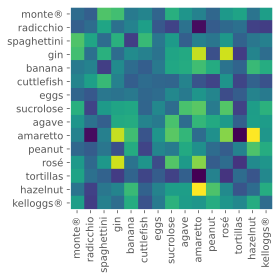

In [73]:
# Graficamos el mapa de calor
fig, ax = plt.subplots()
im = ax.imshow(small_sims)
ax.set_xticks(np.arange(len(small_vector)))
ax.set_yticks(np.arange(len(small_vector)))

ax.set_xticklabels(small_word)
ax.set_yticklabels(small_word)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.show()
# En la diagonal todos los valores son cero
# los colores amarillos tienen alta correlación entre las palabras
# Se ve que la matriz es simetrica en su diagonal
# azules oscuros significan que son palabras mus distantes entre ellas

In [74]:
# Guardamos las palabras y el vector que pudimos inferir del modelo
# desde la lista de item del supermercado amigo
np.savetxt("word.txt",word,fmt="%s")

In [75]:
np.save("vectors.npy",vector)

<a name='5'></a>
## 5. Construcción y visualización de gráficos de red interactivos

In [77]:
# Hacemos importaciones necesarias
# plotly es una libreria para ploteo interactivo alternativo a mathplotlib
import plotly.graph_objects as go
from plotly.offline import plot
# networkx es una libreria diseñada para construir graph en python
# Un graph es basicamente una red de conexiones. Variables que son similares se conectan y
# las que no son similares no se conectan. Ademas se pueden construir subgraph
import networkx as nx

In [78]:
# Guardamos en una variable el archivo word que guardamos anteriormente
words =  np.loadtxt("word.txt", dtype=str)

In [79]:
print(words)

['salt' 'pepper' 'fresh' 'oil' 'sugar' 'butter' 'garlic' 'cheese' 'water'
 'lemon' 'leaves' 'cloves' 'powder' 'chicken' 'milk' 'unsalted' 'eggs'
 'vanilla' 'egg' 'vinegar' 'vegetable' 'baking' 'extract' 'wine'
 'tomatoes' 'parsley' 'brown' 'virgin' 'cinnamon' 'chocolate' 'orange'
 'lime' 'bread' 'mustard' 'seeds' 'bell' 'rice' 'ginger' 'thyme'
 'cilantro' 'broth' 'potatoes' 'beef' 'celery' 'tomato' 'beans' 'parmesan'
 'honey' 'soda' 'zest' 'clove' 'stock' 'sour' 'leaf' 'mushrooms' 'carrots'
 'syrup' 'cayenne' 'bacon' 'pork' 'coconut' 'oregano' 'mayonnaise' 'chili'
 'chile' 'cheddar' 'seasoning' 'nutmeg' 'canola' 'chips' 'mint' 'rosemary'
 'scallions' 'chives' 'peanut' 'breast' 'cornstarch' 'almonds' 'cider'
 'shrimp' 'shallots' 'worcestershire' 'yogurt' 'walnuts' 'spinach' 'cocoa'
 'olives' 'jalapeno' 'pineapple' 'buttermilk' 'balsamic' 'lettuce' 'pasta'
 'turkey' 'cake' 'mozzarella' 'fillets' 'chunks' 'peas' 'chiles'
 'semisweet' 'sausage' 'carrot' 'coriander' 'raisins' 'pecans' 'cher

In [80]:
# Igualmente con el vector que guardamos previamente
vectores = np.load("vectors.npy")

In [81]:
# Chequeamos la longitud de vectors
len(vectores)

909

In [82]:
# Aplicamos la similidad del coseno nuevamente
similitudes = cosine_similarity(vectores,vectores)

In [83]:
# Definimos cero en la diagonal de la matriz donde las similitudes son 1
for i in range(len(vectores)):
    for j in range(len(vectores)):
        if i<=j:
            similitudes[i,j]=False

In [84]:
# Tomamos los indices que tienen similitudes mayores a un determinado valor
indices = np.argwhere(similitudes > 0.65)

In [85]:
# Veamos cuantos indices nos quedan con ese valor de restriccion y cuales son
print('Se tienen: ', len(indices), ' indices')
indices

Se tienen:  1220  indices


array([[ 18,  16],
       [ 30,   9],
       [ 31,   9],
       ...,
       [894, 447],
       [897, 269],
       [900, 318]], dtype=int64)

In [89]:
# Ahora armamos el graph vacio para rellenar con los indices que seleccionamos
G = nx.Graph()

In [91]:
# Con este bucle, se recorren los indices y se hacen las relaciones
# add_edge es de la libreria networkx y lo que hace es agregar un borde entre dos vectores
# En este caso son las palabras en la posición de word[0] y word[1] tienen al menos 
# el valor de similid seteada anteriormente. La relación se va a hacer entre esos dos valores de word.
# Ademas, se agrega un peso para la relación. En este caso se define como la similitud entre las dos 
# palabras ubicadas en los indices 0 y 1
for indice in indices:
    G.add_edge(word[indice[0]],word[indice[1]], weight=similitud[indice[0],indice[1]])

In [94]:
# Para mejorar la visualización se realiza lo siguiente
weight_values = nx.get_edge_attributes(G,"weight")
# Por ejemplo, se puede ver la similitud entre dos palabras
weight_values[('egg', 'eggs')]

0.77710605

In [96]:
# O podemos ver que cantidad de valores de pesos hay y las combinaciones
# todas por arriba del valor de restriccion que pusimos antes
print(len(weight_values))
weight_values 

1220


{('egg', 'eggs'): 0.77710605,
 ('orange', 'lemon'): 0.8303656,
 ('orange', 'lime'): 0.7267693,
 ('orange', 'oranges'): 0.6570845,
 ('orange', 'grapefruit'): 0.725907,
 ('orange', 'tangerine'): 0.892105,
 ('orange', 'clementine'): 0.7914302,
 ('lemon', 'lime'): 0.8191058,
 ('lemon', 'lemons'): 0.71662533,
 ('lemon', 'limes'): 0.6969043,
 ('lemon', 'tangerine'): 0.7803522,
 ('lemon', 'clementine'): 0.67279875,
 ('lime', 'limes'): 0.86432636,
 ('lime', 'tangerine'): 0.6559293,
 ('tomato', 'tomatoes'): 0.7025542,
 ('clove', 'cloves'): 0.9281875,
 ('stock', 'broth'): 0.9406223,
 ('broth', 'consomme'): 0.65763974,
 ('leaf', 'leaves'): 0.8333138,
 ('pork', 'beef'): 0.70366454,
 ('pork', 'lamb'): 0.7866735,
 ('pork', 'veal'): 0.7063191,
 ('pork', 'shoulder'): 0.65169394,
 ('pork', 'venison'): 0.7943371,
 ('pork', 'elk'): 0.6511545,
 ('beef', 'veal'): 0.6794435,
 ('beef', 'venison'): 0.6864783,
 ('beef', 'bison'): 0.7018907,
 ('oregano', 'thyme'): 0.73487854,
 ('oregano', 'rosemary'): 0.6989720

In [277]:
# con nx.spring_layout se puede hacer una representación matemática, donde muestra todos los datos
# en dos dimensiones donde todo esta conectado entre si.
# Se puede ver la documentación agregando '?'
nx.spring_layout?

Signature:
nx.spring_layout(
    G,
    k=None,
    pos=None,
    fixed=None,
    iterations=50,
    threshold=0.0001,
    weight='weight',
    scale=1,
    center=None,
    dim=2,
    seed=None,
)
Docstring:
Position nodes using Fruchterman-Reingold force-directed algorithm.

The algorithm simulates a force-directed representation of the network
treating edges as springs holding nodes close, while treating nodes
as repelling objects, sometimes called an anti-gravity force.
Simulation continues until the positions are close to an equilibrium.

There are some hard-coded values: minimal distance between
nodes (0.01) and "temperature" of 0.1 to ensure nodes don't fly away.
During the simulation, `k` helps determine the distance between nodes,
though `scale` and `center` determine the size and place after
rescaling occurs at the end of the simulation.

Fixing some nodes doesn't allow them to move in the simulation.
It also turns off the rescaling feature at the simulation's end.
In additio

In [97]:
# Hacemos la representación de las posiciones del graph
posiciones = nx.spring_layout(G)

In [98]:
# Podemos visualizar que es
posiciones

{'egg': array([0.29342899, 0.84833914]),
 'eggs': array([0.27934963, 0.80546463]),
 'orange': array([-0.64156753, -0.08599588]),
 'lemon': array([-0.63767588, -0.09761972]),
 'lime': array([-0.64491457, -0.10530667]),
 'tomato': array([-0.33056194, -0.79919559]),
 'tomatoes': array([-0.31628364, -0.76109588]),
 'clove': array([0.94448584, 0.15986386]),
 'cloves': array([0.94604862, 0.14642349]),
 'stock': array([ 0.62352771, -0.6395328 ]),
 'broth': array([ 0.60708761, -0.61978149]),
 'leaf': array([-0.00161575,  0.83423179]),
 'leaves': array([-0.00133366,  0.85612434]),
 'pork': array([0.13767602, 0.00521642]),
 'beef': array([ 0.15642108, -0.00055022]),
 'oregano': array([0.11760469, 0.78962624]),
 'thyme': array([0.1258366 , 0.77159315]),
 'chile': array([0.52635211, 0.32630444]),
 'chili': array([0.55683565, 0.31235608]),
 'canola': array([0.74439847, 0.22445452]),
 'vegetable': array([0.75299442, 0.21667477]),
 'mint': array([-0.38300487,  0.71876466]),
 'cilantro': array([-0.398

In [99]:
# Ahora aplicamos los atributos de la posicion en el graph
nx.set_node_attributes(G,values=posiciones, name="position")

In [100]:
# Definimos algunas listas vacías que se necesitan luego
edge_x = []
edge_y = []
weights = []
ave_x, ave_y = [], []
searches = []
# Si se pone de la siguiente forma y se ejecutan las siguientes celdas, se puede ver la 
# visualización de la relacion de las palabras pero con mayor tamaño a las palabras que se pongan en la busqueda
# de esta forma se identifican rápidamente
# searches = ['potatos', 'gouda', 'crab']

# Este bucle fue extraido de la documentación oficial de plotly usando networkx
# En este primer bucle crea los bordes cuando se hace la visualización
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['position']
    x1, y1 = G.nodes[edge[1]]['position']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    ave_x.append(np.mean([x0, x1]))
    ave_y.append(np.mean([y0, y1]))
    weights.append(f'{edge[0]}, {edge[1]}: {weight_values[(edge[0], edge[1])]}')

    # Esta parte hace el ploteo
edge_trace = go.Scatter(
                        x         = edge_x, 
                        y         = edge_y,
                        opacity   = 0.7,
                        line      = dict(width=2, color='White'),
                        hoverinfo = 'text',
                        mode      = 'lines'
                        )

edge_trace.text = weights


node_x = []
node_y = []
sizes = []

# Este bucle crea los nodos
for node in G.nodes():
    x, y = G.nodes[node]['position']
    node_x.append(x)
    node_y.append(y)
    if node in searches:
        sizes.append(50)
    else:
        sizes.append(15)

# Esto hace el ploteo de todo junto
node_trace = go.Scatter(
                        x         = node_x,  
                        y         = node_y,
                        mode      = 'markers',
                        hoverinfo = 'text',
                        marker    = dict(
                                    showscale = True,
                                    line      = dict(color = 'White'),
                                    # colorscale options
                                    # Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                                    #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                                    #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                                    colorscale   = 'Picnic',
                                    reversescale = False,
                                    color        = [],
                                    opacity      = 0.9,
                                    size         = sizes,
                                    colorbar     = dict(
                                            thickness = 15,
                                            title     = 'Node Connections',
                                            xanchor   = 'left',
                                            titleside = 'right'
                                                        ),
                                    line_width   = 2
                                            )
                        )

invisible_similarity_trace = go.Scatter(
                                        x         = ave_x, 
                                        y         = ave_y,
                                        mode      = 'markers',
                                        hoverinfo = 'text',
                                        marker    = dict(
                                                        color   = [],
                                                        opacity = 0,
                                                        )
                                        )

invisible_similarity_trace.text = weights

In [101]:
node_adjacencies = []
node_text        = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text         = node_text

In [102]:
# Esto define el ploteo final
fig = go.Figure(
                data   = [edge_trace, node_trace, invisible_similarity_trace],
                layout = go.Layout(
                                    title          = 'Network Graph of Word Embeddings',
                                    template       = 'plotly_dark',
                                    titlefont_size = 20,
                                    showlegend     = False,
                                    hovermode      = 'closest',
                                    margin         = dict(
                                                        b = 20,
                                                        l = 5,
                                                        r = 5,
                                                        t = 40
                                                         ),
                                    annotations   = [
                dict(
                text      =  "Adapted from: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow = False,
                xref      = "paper", 
                yref      = "paper",
                x         = 0.005, 
                y         = -0.002 
                    ) 
                                                    ],
                                    xaxis = dict(showgrid        = False, 
                                                 zeroline        = False, 
                                                 showticklabels  = False
                                                ),
                                    yaxis = dict( showgrid       = False, 
                                                  zeroline       = False, 
                                                  showticklabels = False
                                                )
                                   )
                )

plot(fig)

'temp-plot.html'

Ya debería estar viendo el grafico interactivo en una pestaña aparte.

Puede ver con el ratón las palabras (nodos) y sus relaciones (líneas).

Colores rojos, rosados significan altamente relacionados. Colores azules, celestes, menor cantidad de palabras relacionadas.(ojo que la gama de colores se puede cambiar, aca se uso Picnic).

Puede hacer zoom creando un cuadrado en el sector que quiere ver con detalle.

Con docle clic se puede salir del zoom.

Si se para sobre los nodos verá las palabras de los ingrediente y si se para sobre las lineas verá el valor de similitud entre los dos nodos.

**RECUERDE QUE NUNCA LE DIJIMOS AL MODELO COMO SE RELACIONAN LAS PALABRAS! Todo lo aprendió de ver las recetas!**

<a name='6'></a>
## 6. Graded Quiz: Test your Project Understanding

***
<font size="2" color="red"><b> PREGUNTA 1 </b></font>

¿Por qué hemos eliminado algunas palabras clave?

- Estas palabras podrían dificultar el aprendizaje de nuestro modelo, ya que no siempre son informativas.
- Estas palabras no estaban en nuestro vocabulario, por lo que no se podían utilizar.


<font size="2" color="red"><b> PREGUNTA 2 </b></font>

¿Cuál es la diferencia entre los enfoques de la Bolsa Continua de Palabras (CBOW) y Skip-Gram (SG) para Word2Vec? 

- Skip-Gram utiliza el contexto para predecir una palabra dada, mientras que CBOW utiliza una palabra dada para predecir el contexto.
- CBOW utiliza varias palabras para predecir el contexto, mientras que Skip-Gram utiliza varias palabras para predecir una sola.
- El CBOW utiliza el contexto para predecir una palabra determinada, mientras que el Skip-Gram utiliza una palabra determinada para predecir el contexto.
- En realidad, son lo mismo, sólo que se alimentan de datos en un orden diferente.

<font size="2" color="red"><b> PREGUNTA 3 </b></font>

¿Por qué no es eficaz el uso de un mapa de calor en nuestros resultados?

- La mitad de los cálculos de la matriz de similitud se desperdiciarían.
- Se necesita mucha potencia de cálculo, y sería muy difícil leer cientos de palabras en ambas dimensiones en un gráfico.
- Las puntuaciones de similitud del mapa de calor son una aproximación.

<font size="2" color="red"><b> PREGUNTA 4 </b></font>

¿Cuáles son las desventajas de utilizar el enfoque que tenemos, específicamente en el caso de nuevos datos? ¿Qué pasa con los datos que ya tiene?

- Todas las métricas de distancia tienen que ser evaluadas cada vez que se introduce un nuevo valor. Esto es caro y puede ser lento.
- Word2Vec, como todos los modelos de PNL, estará sesgado en función de nuestros datos de entrenamiento. Por ejemplo, nuestras recetas están orientadas principalmente a Occidente. Es posible que las recetas de regiones tradicionales en zonas menos populares del mundo no estén siempre representadas en este modelo.
- Las palabras que no están en nuestro modelo Word2Vec no se tratan directamente, y darán lugar a un error.

<font size="2" color="red"><b> PREGUNTA 5 </b></font>

¿Qué enfoques utilizaría para mejorar o cambiar este modelo?

***

<details>
   <summary><font size="2" color="darkblue"><b> Click para la respuesta</b></font></summary>

Respuesta 1: Estas palabras podrían dificultar el aprendizaje de nuestro modelo, ya que no siempre son informativas..

Respuesta 2: El CBOW utiliza el contexto para predecir una palabra determinada, mientras que el Skip-Gram utiliza una palabra determinada para predecir el contexto.
  
Respuesta 3: 
    
- La mitad de los cálculos de la matriz de similitud se desperdiciarían.
- Se necesita mucha potencia de cálculo, y sería muy difícil leer cientos de palabras en ambas dimensiones en un gráfico.
    
Respuesta 4: Todas.
    
Respuesta 5:
    
PCA: Creo que un algoritmo de reducción de la dimensionalidad, como un autoencoder o un PCA, podría ser útil para añadir datos a una estructura gráfica existente. Además, también podría ser inteligente añadir algunos datos artificiales de manera que las palabras menos comunes no arrojen exactamente un error, incluso si el modelo tiene menos confianza en estas palabras (¿está de acuerdo con este segundo punto? ¡Para reflexionar!).

    
</details>